## Imports

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import random
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
# from matplotlib import animation
# from JSAnimation.IPython_display import display_animation
# import gym
import scipy.stats as stats
from scipy.stats import norm
from collections import namedtuple
import statistics
import time
import os
from collections import deque
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

import yfinance as yf
import datetime as dt

import pickle

import import_ipynb
import Generate_Data
import Environment

/Users/weihangoh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/weihangoh/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
/Users/weihangoh/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100

Index(['LogReturn', 'RSI2', 'MA10', 'MA30', 'MA200', 'EMA10', 'EMA30',
       'EMA200', 'ROC10', 'ROC30', 'MOM10', 'MOM30', '%K10', '%D10', '%K30',
       '%D30', 'VIX', 'RiskFreeRate', 'Volume', 'Adj Close', 'Close', 'High',
       'Low', 'Open', 'delta', 'gamma', 'theta', 'vega', 'rho', 'vol',
       'OptionPrice'],
      dtype='object')
(3242, 31)
(440, 31)
(3242, 8)
(440, 8)
(3242, 10)
(440, 10)


<string>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:49: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
<string>:50: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


## Defining Model Classes
- Environment: Simulates the trading environment, handling state transitions, reward calculation, and interaction with the stock and option data.

- BrainDQN: Implements the DQN agent's logic, including policy selection, experience replay, epsilon-greedy action selection, and network updates.

- ReplayMemory: Manages the experience replay memory, storing agent experiences and sampling them for training.

- AgentActionValueBase: Provides the agent interface for interacting with BrainDQN, including action selection, memory storage, and updating the model.


In [2]:
class ReplayMemory:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)
    
    def push(self, state, action, state_next, reward):
        self.memory.append((state, action, state_next, reward))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [3]:
class AgentActionValueBase:
    def __init__(self, brain):
        self.brain = brain

    def get_action(self, state, step=0, episode=0):
        return self.brain.decide_action(state, step=step, episode=episode)

    def memorize(self, state, action, state_next, reward):
        self.brain.memory.push(state, action, state_next, reward)

    def update_agent(self):
        self.brain.replay()

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import copy
from collections import namedtuple

# Constants
CAPACITY = 1000000  # Replay memory capacity
BATCH_SIZE = 64     # Batch size for training
GAMMA = 0.99        # Discount factor
FREQ_UPDATE_TARGET = 1000

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class BrainDQN:
    def __init__(self, num_states, num_actions):
        self.num_states = num_states
        self.num_actions = num_actions
        self.freq_update_target = FREQ_UPDATE_TARGET
        self.count_replay = 0
        self.memory = ReplayMemory(CAPACITY)

        # Device configuration (CPU or GPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Construct the neural network
        input_dim = self.num_states
        output_dim = self.num_actions
        hidden_layers = [16, 16]
        activation_func = nn.ReLU()

        # Build the model
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(activation_func)
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers).to(self.device)

        # Initialize target model
        self._target_model = copy.deepcopy(self.model).to(self.device)
        self._target_model.eval()

        # Set optimizer and loss function
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

    def save(self, file_name):
        torch.save(self.model.state_dict(), file_name)

    def load(self, file_name):
        self.model.load_state_dict(torch.load(file_name))
        self._target_model = copy.deepcopy(self.model)

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return

        # Sample mini-batch from memory
        transitions = self.memory.sample(BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        # Convert to tensors
        #state_batch = torch.tensor(batch.state, dtype=torch.float32).to(self.device)
        state_batch = torch.tensor(
            [s.to_numpy(dtype=np.float32) for s in batch.state],
            dtype=torch.float32
        ).to(self.device)
        action_batch = torch.tensor(batch.action, dtype=torch.long).unsqueeze(1).to(self.device)
        reward_batch = torch.tensor(batch.reward, dtype=torch.float32).to(self.device)

        # Handle next states
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool).to(self.device)
        non_final_next_states = torch.cat([torch.tensor(s.to_numpy(), dtype=torch.float32).unsqueeze(0) for s in batch.next_state if s is not None]).to(self.device)

        # Compute Q(s, a) for current states
        state_action_values = self.model(state_batch).gather(1, action_batch)

        # Compute V(s') for next states
        next_state_values = torch.zeros(BATCH_SIZE, device=self.device)
        with torch.no_grad():
            if non_final_next_states.size(0) > 0:
                next_state_values[non_final_mask] = self._target_model(non_final_next_states).max(1)[0]
        # Compute expected Q values
        expected_state_action_values = reward_batch + (GAMMA * next_state_values)

        # Compute loss
        loss = self.loss_fn(state_action_values.squeeze(), expected_state_action_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.count_replay += 1
        if self.count_replay % self.freq_update_target == 0:
            self.update_target_model()

    def decide_action(self, state, step=None, episode=None):
        if episode is not None:
            epsilon = 0.5 * (1 / (episode + 1))
        else:
            epsilon = 0

        if np.random.uniform(0, 1) >= epsilon:
            with torch.no_grad():
                state_tensor = torch.tensor(state.to_numpy(), dtype=torch.float32).unsqueeze(0).to(self.device)
                q_values = self.model(state_tensor)
                action = q_values.max(1)[1].item()
        else:
            action = np.random.randint(0, self.num_actions)

        return action

    def update_target_model(self):
        self._target_model.load_state_dict(self.model.state_dict())


## Model Training

In [11]:
def train_agent(env, agent, num_episodes=1000, num_steps=30, gamma=0.99):
    """
    Trains the agent in the given environment.

    Parameters:
    - env: The trading environment (DeltaHedgingEnv).
    - agent: The RL agent (AgentActionValueBase).
    - num_episodes: The number of training episodes.
    - num_steps: The number of steps per episode.
    - gamma: Discount factor for future rewards.

    Returns:
    - pl_history: A list containing the P&L history for each episode.
    - reward_history: A list containing the cumulative reward history for each episode.
    """
    
    pl_history = []  # Profit and loss history for each episode
    reward_history = []  # Total reward history for each episode
    std_pl_history = []  # Standard deviation of P&L for each episode ; added this 

    last_30_pl = []
    
    for episode in range(num_episodes):
        state = env.reset()  # Reset the environment and get the initial state
        total_reward = 0  # Track total reward for the episode
        pl_episode = []  # Track portfolio value (P&L) for the episode

        for step in range(num_steps):
            # Agent takes an action based on the current state
            action = agent.get_action(state, step=step, episode=episode)
            
            # Environment returns the next state, reward, and whether the episode is done
            next_state, reward, done, pv = env.step(action)
            
            # Accumulate total reward, discounted by gamma (for future rewards)
            total_reward += reward * np.power(gamma, episode)
            
            # Store the portfolio value (P&L) for the step
            pl_episode.append(pv)
            
            # Memorize the experience
            agent.memorize(state, action, next_state, reward)
            
            # Update the agent
            agent.update_agent()

            # Move to the next state
            state = next_state
            
            # If the episode is done, break out of the loop
            if done:
                break
        
        # At the end of the episode, calculate the total P&L and reward
        pl_total = sum(pl_episode)
        pl_history.append(pl_total)
        reward_history.append(total_reward)
        #std_pl_history.append(np.std(pl_episode))

        last_30_pl.append(pl_total)
        if len(last_30_pl) > 30:
            last_30_pl.pop(0)

        if episode >= 30:
            std = np.std(last_30_pl)
            std_pl_history.append(std)
        else:
            std_pl_history.append(np.nan)

        # if episode % 30 == 0 and episode != 0:
        #     std_pl_history.append(np.std(pl_episode[-30:]))  # Compute std dev of P&L for the episode # added this
        
        # Print progress every 100 episodes
        if episode % 100 == 0:
            print(f"Episode {episode}/{num_episodes}, Total Reward: {total_reward}, P&L: {pl_total}, Std Dev P&L: {std_pl_history[-1]}") # added std dev part
    
    return pl_history, reward_history, std_pl_history # added std dev

Episode 0/1000, Total Reward: -30541.60525917425, P&L: 19.02433414911178, Std Dev P&L: nan


/var/folders/hz/cptf1fsx30vfjg68b57f0w4h0000gn/T/ipykernel_21437/1574897309.py:68: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  state_batch = torch.tensor(


Episode 100/1000, Total Reward: -358.52814359608817, P&L: 119.66266278601552, Std Dev P&L: 205.18938644471305
Episode 200/1000, Total Reward: -11257.22683535358, P&L: 327.6315548300354, Std Dev P&L: 219.47963972102642
Episode 300/1000, Total Reward: -2428.645154054673, P&L: -130.2861379778065, Std Dev P&L: 123.23818951760828
Episode 400/1000, Total Reward: -1031.0107723169926, P&L: 30.75557628856265, Std Dev P&L: 151.42769593990616
Episode 500/1000, Total Reward: -11.123780414826715, P&L: 5.457842008087596, Std Dev P&L: 138.80600876336038
Episode 600/1000, Total Reward: -4.098792282646927, P&L: 200.32641318365484, Std Dev P&L: 187.46067485953816
Episode 700/1000, Total Reward: -0.3815114335237067, P&L: -45.821887268336155, Std Dev P&L: 126.94332546545213
Episode 800/1000, Total Reward: -0.13382237185808762, P&L: 36.12527054564376, Std Dev P&L: 122.26511250049711
Episode 900/1000, Total Reward: -0.7102008969764764, P&L: 187.4587967815506, Std Dev P&L: 161.3472906576525


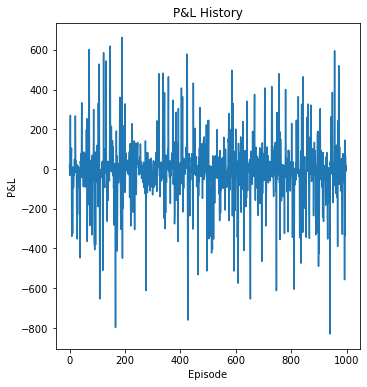

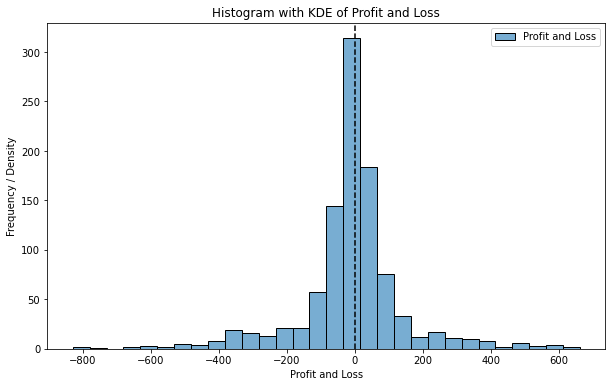

In [12]:
##Getting train datasets
features_train = Generate_Data.features_train
df_stock_train = Generate_Data.df_stock_train
call_options_train = Generate_Data.call_options_train

# Set up your environment with real AAPL stock and option data
env_train = Environment.Environment(
    stock_data=df_stock_train,
    option_data=call_options_train,
    features_data=features_train,
    T=30,
    n_steps=30,
    num_sold_opt=100,
    kappa=0.1,
    alpha=0.001
)
num_states = env_train.num_states
num_actions = env_train.num_actions

# Initialize the agent's brain
brain = BrainDQN(num_states, num_actions)

# Initialize the agent
dqn_agent = AgentActionValueBase(brain)

# Train the agent
pl_history, reward_history, std_pl = train_agent(env_train, dqn_agent, num_episodes=1000, num_steps=30)

plt.figure(figsize=(12, 6))

# Plot P&L history
plt.subplot(1, 2, 1)
plt.plot(pl_history)
plt.title("P&L History")
plt.xlabel("Episode")
plt.ylabel("P&L")

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(pl_history, kde=False, bins=30, label="Profit and Loss", alpha=0.6)

plt.axvline(0, color='k', linestyle='--')  # Mark zero for reference
plt.xlabel("Profit and Loss")
plt.ylabel("Frequency / Density")
plt.title("Histogram with KDE of Profit and Loss")
plt.legend()
plt.show()

plt.show()

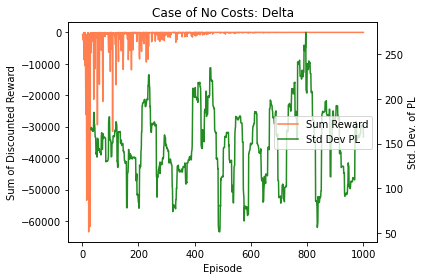

In [12]:
## DQN

episodes = np.array(list(range(1, len(reward_history) + 1)))

# Create a figure for dual-axis plotting
fig = plt.figure(figsize=[6, 4])
ax1 = fig.add_subplot(111)

# Plot Sum of Discounted Reward
ax1.plot(episodes, reward_history, color='coral', label='Sum Reward')
ax1.set_xlabel('Episode')
ax1.set_ylabel("Sum of Discounted Reward")
h1, l1 = ax1.get_legend_handles_labels()

# Create a secondary axis for Std Dev PL
ax2 = ax1.twinx()
ax2.plot(episodes, std_pl, color='forestgreen', label='Std Dev PL')
ax2.set_ylabel("Std. Dev. of PL")
h2, l2 = ax2.get_legend_handles_labels()

# Combine legends for both axes and set the title
ax2.legend(h1 + h2, l1 + l2, loc='center right')
ax1.set_title('Case of No Costs: Delta')

plt.tight_layout()
plt.show()

In [9]:
# Save the agent (if additional attributes need to be saved)
with open("models/dqn_trained_agent.pkl", "wb") as f:
    pickle.dump(dqn_agent, f)

## Notebook Summary
Train DQN model, save as dqn_trained_brain

In [13]:
#!pip install torchviz


from torchviz import make_dot

# Create an instance of BrainDQN
brain_dqn = BrainDQN(num_states=num_states, num_actions=num_actions)

# Generate a random sample input to pass through the model
sample_input = torch.randn(1, num_states).to(brain_dqn.device)

# Forward pass through the model to get the output
output = brain_dqn.model(sample_input)

# Visualize the model architecture
dot = make_dot(output, params=dict(brain_dqn.model.named_parameters()))
dot.format = 'png'  # Choose format (e.g., 'png' or 'svg')
dot.render("NN_archi/dqn_model_visualization")  # Save the visualization as 'model_visualization.png'


'model_visualization.png'